In [115]:
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import timedelta
from scipy.stats import pearsonr
from sklearn.manifold import TSNE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import LeavePGroupsOut
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import seaborn as sns

# display all columns and rows
pd.set_option('display.max_colwidth',-1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [54]:
NUM_DAYS_USED = 14
NUM_DAYS_BLOCKED = 1

behavior_names = [
                  'calllog',
                  'sms_in',
                  'sms_out',
                  'unlock',
                  'conver',
                  'sleep',
                  'act_invehicle',
                  'act_onbike',
                  'act_onfoot',
                  'act_still',
                  'act_tilting',
                  'act_unknown',
                  'light',
                  'audio_amp',
                  'audio_noise',
                  'audio_silence',
                  'audio_voice'                  
                 ]

def get_p_values(df):
    df1 = df.dropna()._get_numeric_data()
    coeffmat = np.zeros((df1.shape[1], df1.shape[1]))
    pvalmat = np.zeros((df1.shape[1], df1.shape[1]))

    for i in range(df1.shape[1]):    
        for j in range(df1.shape[1]):        
            corrtest = pearsonr(df1[df1.columns[i]], df1[df1.columns[j]])  

            coeffmat[i,j] = corrtest[0]
            pvalmat[i,j] = corrtest[1]

    dfcoeff = pd.DataFrame(coeffmat, columns=df1.columns, index=df1.columns)

    dfpvals = pd.DataFrame(pvalmat, columns=df1.columns, index=df1.columns)
    return dfpvals

# add previous ema

In [64]:
ema = pd.read_csv('table_ema_'+str(NUM_DAYS_USED)+'_'+str(NUM_DAYS_BLOCKED)+'.csv')
ema = ema.drop(['Unnamed: 0'], axis=1)
ema['day'] = pd.to_datetime(ema['day'])
print('num of ema: ', len(ema))
print('num of columns: ', len(ema.columns))

num of ema:  5027
num of columns:  118


In [65]:
# use previous ema exactly "NUM_DAY_MINUS" days ago
# change the commented out line of code to replace nan with mean
NUM_DAY_MINUS = 7
EMA_ITEM = 'ema_score'
users = [
'u004_rct@eureka',
'u005_rct@eureka',
'u006_rct@eureka',
'u007_rct@eureka',
'u008_rct@eureka',
'u009_rct@eureka',
'u010_rct@eureka',
'u011_rct@eureka',
'u012_rct@eureka',
'u013_rct@eureka',
'u014_rct@eureka',
'u015_rct@eureka',
'u016_rct@eureka',
'u017_rct@eureka',
'u018_rct@eureka',
'u019_rct@eureka',
'u020_rct@eureka',
'u021_rct@eureka',
'u022_rct@eureka',
'u023_rct@eureka',
'u024_rct@eureka',
'u025_rct@eureka',
'u026_rct@eureka',
'u027_rct@eureka',
'u028_rct@eureka',
'u029_rct@eureka',
'u030_rct@eureka',
'u031_rct@eureka',
'u032_rct@eureka',
'u033_rct@eureka',
'u034_rct@eureka',
'u035_rct@eureka',
'u036_rct@eureka',
'u037_rct@eureka',
'u038_rct@eureka',
'u039_rct@eureka',
'u040_rct@eureka',
'u041_rct@eureka',
'u042_rct@eureka',
'u043_rct@eureka',
'u044_rct@eureka',
'u045_rct@eureka',
'u046_rct@eureka',
'u047_rct@eureka',
'u048_rct@eureka',
'u049_rct@eureka',
'u050_rct@eureka',
'u051_rct@eureka',
'u052_rct@eureka',
'u053_rct@eureka',
'u054_rct@eureka',
'u055_rct@eureka',
'u056_rct@eureka',
'u057_rct@eureka',
'u058_rct@eureka',
'u059_rct@eureka',
'u060_rct@eureka',
'u061_rct@eureka',
'u062_rct@eureka',
'u063_rct@eureka',
'u064_rct@eureka',
'u065_rct@eureka',
'u066_rct@eureka',
'u067_rct@eureka',
'u068_rct@eureka',
'u069_rct@eureka',
'u070_rct@eureka',
'u071_rct@eureka',
'u072_rct@eureka',
'u073_rct@eureka',
]
print(len(users))
new_ema = pd.DataFrame()
for user in users:
    ema_user = ema.loc[ema.eureka_id == user[0:4]]
    ema_user = ema_user.set_index('day')
    days_index = ema_user.index
    previous_ema_items = []
    for day in days_index:
        previous_day = day - timedelta(days=NUM_DAY_MINUS)
        if previous_day in ema_user.index:
            previous_ema_items.append(ema_user.loc[previous_day][EMA_ITEM])
        else:
            previous_ema_items.append(float('nan'))
#             previous_ema_items.append(ema['ema_score'].mean())
    ema_user['prev_' + EMA_ITEM] = previous_ema_items
    ema_user = ema_user.reset_index()
    new_ema = pd.concat([new_ema, ema_user])
new_ema = new_ema.drop(['index'], axis=1)

70


/homes/gws/joyhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:95: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [69]:
new_ema.to_csv(r'table_ema_'+str(NUM_DAYS_USED)+'_'+str(NUM_DAYS_BLOCKED)+'_prev'+str(NUM_DAY_MINUS)+'.csv')

In [70]:
def get_filtered_ema(NUM_GOOD_DAYS_REQUIRED, FILENAME):
    '''
    only keeps ema data with strictly more than "NUM_GOOD_DAYS_REQUIRED" days of behavioral data 
    for all activities
    '''
    ema = pd.read_csv(FILENAME)
    ema = ema.drop(['Unnamed: 0'], axis=1)
    table0 = ema
    table0_filtered = table0.loc[table0.calllog_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.sms_in_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.sms_out_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.unlock_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.conver_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.sleep_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.act_invehicle_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.act_onbike_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.act_onfoot_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.act_still_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.act_tilting_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.act_unknown_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.light_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.audio_amp_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.audio_noise_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.audio_silence_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.audio_voice_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    ema = table0_filtered
    return ema

In [75]:
FILE = 'table_ema_'+str(NUM_DAYS_USED)+'_'+str(NUM_DAYS_BLOCKED)+'_prev'+str(NUM_DAY_MINUS)+'.csv'
ema = get_filtered_ema(7, FILE)

In [76]:
len(ema)

779

In [78]:
EMA_ITEM = 'ema_score' # what we are predicting
NUM_TEST_PER_USER = 10

ema['day'] = pd.to_datetime(ema['day'])
ema = ema.set_index('day')
ema = ema.sort_index()
ema = ema.reset_index()
ema_counts = ema.groupby('eureka_id').count()
MIN_USER_DATA = 25
ema_counts = ema_counts.loc[ema_counts.day > MIN_USER_DATA]
valid_users = ema_counts.index
all_users = ema['eureka_id'].drop_duplicates()
ema = ema.set_index('eureka_id')
for u in all_users:
    if u not in valid_users:
        ema = ema.drop(u)
ema = ema.reset_index()
print('users included:',len(ema.groupby('eureka_id').count()))
POPULATION_MEAN = ema[EMA_ITEM].mean()
print('population mean is:', POPULATION_MEAN)

print('ema before drop nan', len(ema))
ema = ema.dropna(subset=['prev_' + EMA_ITEM])
print('ema before drop nan', len(ema))

users included: 14
population mean is: -7.696107784431137
ema before drop nan 668
ema before drop nan 655


# Correlations

In [79]:
def get_filtered_ema_from_table(NUM_GOOD_DAYS_REQUIRED, current_ema):
    '''
    only keeps ema data with strictly more than "NUM_GOOD_DAYS_REQUIRED" days of behavioral data 
    for all activities
    '''
    table0 = current_ema
    table0_filtered = table0.loc[table0.calllog_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.sms_in_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.sms_out_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.unlock_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.conver_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.sleep_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.act_invehicle_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.act_onbike_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.act_onfoot_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.act_still_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.act_tilting_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.act_unknown_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.light_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.audio_amp_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.audio_noise_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.audio_silence_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    table0_filtered = table0_filtered.loc[table0_filtered.audio_voice_num_good_days >= NUM_GOOD_DAYS_REQUIRED]
    new_ema = table0_filtered
    return new_ema

In [81]:
filtered_ema = get_filtered_ema_from_table(7, ema)
print(len(filtered_ema))
print('users included:',len(filtered_ema.groupby('eureka_id').count()))

655
users included: 14


In [82]:
corr_table = ema.corr(method ='pearson') 
row_index = [r for r in corr_table.index if "ema" in r]
col_index = [c for c in corr_table.columns if 'ema' not in c]
corr_table_small = corr_table.loc[row_index, col_index]
p_table = get_p_values(ema)
p_table_small = p_table.loc[row_index, col_index]

## correlations between stability index and ema 

In [83]:
row_index = [r for r in corr_table.index if "ema" in r]
col_index_med_mean = [c for c in corr_table.columns if 'med_mean' in c and 'raw' not in c]
corr_table_small_med_mean = corr_table.loc[row_index, col_index_med_mean]
# print r in desceding order for each ema score
ordered_list_all = pd.DataFrame()
for i in corr_table_small_med_mean.index:
#     print(i)
    ordered_list = corr_table_small_med_mean.loc[i].sort_values(ascending=False).rename('diff')
    ordered_list = ordered_list.to_frame()
    ordered_list = ordered_list.reset_index()
#     print(ordered_list)
    means = []
    stds = []
    num_days = []
    pvals_diff = []
    pvals_mean = []
    pvals_std = []
    pvals_num_days = []
    for item in ordered_list['index']:
        pvals_diff.append(p_table.loc[i][item])
        
        if behavior_names[0] in item:
            means.append(corr_table_small.loc[i][behavior_names[0] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[0] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[0] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[0] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[0] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[0] + '_num_good_days'])
        if behavior_names[1] in item:
            means.append(corr_table_small.loc[i][behavior_names[1] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[1] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[1] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[1] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[1] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[1] + '_num_good_days'])
        if behavior_names[2] in item:
            means.append(corr_table_small.loc[i][behavior_names[2] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[2] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[2] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[2] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[2] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[2] + '_num_good_days'])
        if behavior_names[3] in item:
            means.append(corr_table_small.loc[i][behavior_names[3] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[3] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[3] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[3] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[3] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[3] + '_num_good_days'])
        if behavior_names[4] in item:
            means.append(corr_table_small.loc[i][behavior_names[4] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[4] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[4] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[4] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[4] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[4] + '_num_good_days'])
        if behavior_names[5] in item:
            means.append(corr_table_small.loc[i][behavior_names[5] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[5] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[5] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[5] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[5] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[5] + '_num_good_days'])
        if behavior_names[6] in item:
            means.append(corr_table_small.loc[i][behavior_names[6] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[6] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[6] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[6] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[6] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[6] + '_num_good_days'])
        if behavior_names[7] in item:
            means.append(corr_table_small.loc[i][behavior_names[7] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[7] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[7] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[7] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[7] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[7] + '_num_good_days'])
        if behavior_names[8] in item:
            means.append(corr_table_small.loc[i][behavior_names[8] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[8] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[8] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[8] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[8] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[8] + '_num_good_days'])
        if behavior_names[9] in item:
            means.append(corr_table_small.loc[i][behavior_names[9] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[9] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[9] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[9] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[9] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[9] + '_num_good_days'])
        if behavior_names[10] in item:
            means.append(corr_table_small.loc[i][behavior_names[10] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[10] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[10] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[10] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[10] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[10] + '_num_good_days'])
        if behavior_names[11] in item:
            means.append(corr_table_small.loc[i][behavior_names[11] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[11] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[11] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[11] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[11] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[11] + '_num_good_days'])
        if behavior_names[12] in item:
            means.append(corr_table_small.loc[i][behavior_names[12] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[12] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[12] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[12] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[12] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[12] + '_num_good_days'])
        if behavior_names[13] in item:
            means.append(corr_table_small.loc[i][behavior_names[13] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[13] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[13] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[13] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[13] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[13] + '_num_good_days'])
        if behavior_names[14] in item:
            means.append(corr_table_small.loc[i][behavior_names[14] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[14] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[14] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[14] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[14] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[14] + '_num_good_days'])
        if behavior_names[15] in item:
            means.append(corr_table_small.loc[i][behavior_names[15] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[15] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[15] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[15] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[15] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[15] + '_num_good_days'])
        if behavior_names[16] in item:
            means.append(corr_table_small.loc[i][behavior_names[16] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[16] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[16] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[16] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[16] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[16] + '_num_good_days'])
    ordered_list['mean'] = means
    ordered_list['std'] = stds                                     
    ordered_list['p_diff'] = pvals_diff
    ordered_list['p_mean'] = pvals_mean
    ordered_list['p_std'] = pvals_std                                     
    ordered_list['ema_item'] = [i] * len(ordered_list)
    ordered_list_all = pd.concat([ordered_list_all, ordered_list])

ordered_list_all 

,index,diff,mean,std,p_diff,p_mean,p_std,ema_item
0,unlock_med_mean,0.393254,0.438417,0.218021,1.184982e-25,3.826472e-32,1.729414e-08,ema_CALM
1,sms_in_med_mean,0.276026,0.282148,0.273239,6.432375e-13,1.877847e-13,1.115218e-12,ema_CALM
2,sms_out_med_mean,0.275536,0.295361,0.271106,7.088203e-13,1.185818e-14,1.692229e-12,ema_CALM
3,audio_silence_med_mean,0.194902,-0.025735,0.146164,4.985427e-07,5.108636e-01,1.741670e-04,ema_CALM
4,sms_out_med_mean_normal,0.194105,0.295361,0.271106,5.559770e-07,1.185818e-14,1.692229e-12,ema_CALM
5,audio_noise_med_mean,0.193023,0.023656,0.159291,6.441859e-07,5.456055e-01,4.219537e-05,ema_CALM
6,act_onfoot_med_mean,0.192475,0.153333,0.224551,6.938885e-07,8.145646e-05,6.235704e-09,ema_CALM
7,unlock_med_mean_normal,0.162157,0.438417,0.218021,3.048933e-05,3.826472e-32,1.729414e-08,ema_CALM
8,calllog_med_mean_normal,0.148711,0.139176,0.055757,1.334753e-04,3.535645e-04,1.540486e-01,ema_CALM
9,sms_in_med_mean_normal,0.119935,0.282148,0.273239,2.106909e-03,1.877847e-13,1.115218e-12,ema_CALM


In [ ]:
ordered_list_all['p_diff'] = ordered_list_all['p_diff']*17

## correlations between stability index and mean

In [84]:
corr_mean = pd.DataFrame()
absolutes = []
normals = []
absolute_normals = []
pvals_absolute = []
pvals_normal = []
pvals_absolute_normals = []
for behavior in behavior_names:
    absolutes.append(corr_table.loc[behavior + '_med_mean', behavior + '_avg'])
    normals.append(corr_table.loc[behavior + '_med_mean_normal', behavior + '_avg'])
    absolute_normals.append(corr_table.loc[behavior + '_med_mean', behavior + '_med_mean_normal'])
    pvals_absolute.append(p_table.loc[behavior + '_med_mean', behavior + '_avg'])
    pvals_normal.append(p_table.loc[behavior + '_med_mean_normal', behavior + '_avg'])
    pvals_absolute_normals.append(p_table.loc[behavior + '_med_mean', behavior + '_med_mean_normal'])
corr_mean['behavior'] = behavior_names
corr_mean['abs_diff&mean'] = absolutes
corr_mean['normal_diff&mean'] = normals
corr_mean['abs&normal'] = absolute_normals

corr_mean['p_abs'] = pvals_absolute
corr_mean['p_normal'] = pvals_normal

corr_mean['p_abs_normal'] = pvals_absolute_normals

corr_mean = corr_mean.set_index('behavior')

corr_mean

,abs_diff&mean,normal_diff&mean,abs&normal,p_abs,p_normal,p_abs_normal
behavior,,,,,,
calllog,0.916623,0.231471,0.164982,3.181376e-262,2.043396e-09,2.201432e-05
sms_in,0.944311,0.387486,0.281945,1.971455e-317,6.815077e-25,1.957046e-13
sms_out,0.952715,0.362237,0.269413,0.000000e+00,9.677194e-22,2.349806e-12
unlock,0.839042,0.334112,0.030700,8.927907e-175,1.517238e-18,4.328125e-01
conver,0.739167,0.180785,-0.279585,3.458301e-114,3.217781e-06,3.156254e-13
sleep,0.124040,0.201233,-0.798555,1.468835e-03,2.063388e-07,4.279013e-146
act_invehicle,0.762415,0.265414,0.013914,1.482101e-125,5.057070e-12,7.222690e-01
act_onbike,0.776668,-0.043357,-0.109537,3.406742e-133,2.678499e-01,5.008825e-03
act_onfoot,0.869794,-0.024943,-0.201472,1.667762e-202,5.239696e-01,1.994810e-07


In [85]:
corr_mean['normal_diff&mean'].mean()

0.3044148740993883

In [86]:
corr_mean['abs_diff&mean'].mean()

0.6454916291102034

# T-SNE

In [97]:
params = {'n_estimators': 300, 'max_depth': 3, 'min_samples_split': 2, 'learning_rate': 0.17} 
model = GradientBoostingRegressor(**params)

baseline = [c for c in ema.columns if 'avg' in c or 'std' in c]
just_diff = [c for c in ema.columns if 'med_mean' in c and 'raw' not in c]
just_diff_absolute = [c for c in ema.columns if 'med_mean' in c and 'normal' not in c and 'raw' not in c]
just_diff_normal = [c for c in ema.columns if 'med_mean_normal' in c]
raw_fea = [c for c in ema.columns if 'raw' in c]
all_fea = just_diff + baseline 
prev_ema = [c for c in ema.columns if ('prev_' + EMA_ITEM) in c]
all_fea_prev_ema = all_fea + prev_ema
baseline_diff_absolute = baseline + just_diff_absolute
baseline_diff_normal = baseline + just_diff_normal
baseline_diff_raw = baseline + raw_fea
all_fea_raw = all_fea + raw_fea
print('length of baseline should be 34:', len(baseline))
print('length of just_diff_normal should be 17:', len(just_diff_normal))
print('length of baseline_diff_normal should be 51:', len(baseline_diff_normal))


feature_sets = [
    prev_ema,
    prev_ema,
    baseline,
    just_diff_normal,
    baseline_diff_normal,
]
feature_sets_names = [
    'prev_ema',
    'mean_predictor',
    'baseline_mean_std',
    'just_diff_normal',
    'baseline_diff_normal',
]

length of baseline should be 34: 34
length of just_diff_normal should be 17: 17
length of baseline_diff_normal should be 51: 51


[[ 54.964687  17.819016]
 [ 54.851673  18.280828]
 [ 53.66358   18.203627]
 ...
 [ 37.181767 -44.63394 ]
 [ 36.210533 -44.231827]
 [ 35.43203  -44.227146]]
655
num of users 14


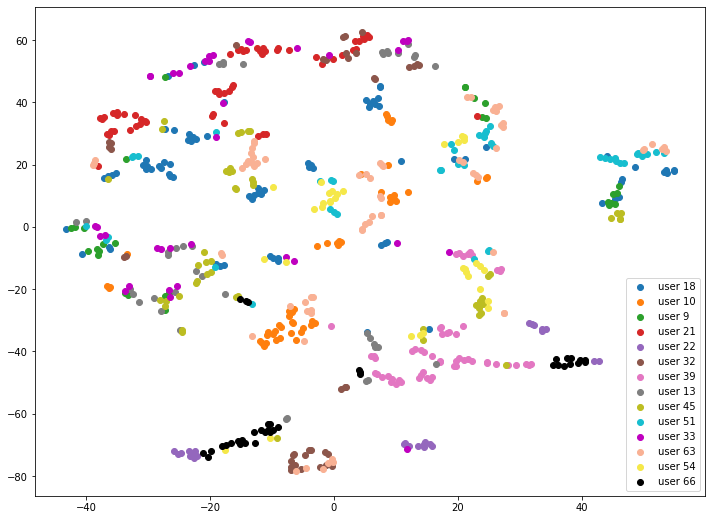

In [98]:
N_COMPONENTS = 2
PERPLEXITY = 10
tsne = TSNE(n_components=N_COMPONENTS, perplexity = PERPLEXITY, random_state=0)
X = ema[feature_sets[4]]
y = ema['eureka_id']
X_2d = tsne.fit_transform(X)
print(X_2d)
print(len(X_2d))
target_names = []

for j in range(len(y)):
    if y.iloc[j] not in target_names:
        target_names.append(y.iloc[j])
target_ids = range(len(target_names))
print('num of users', len(target_ids))
target_labels = ['user 18', 'user 10', 'user 9', 'user 21', 'user 22', 'user 32', 
                 'user 39', 'user 13', 'user 45', 'user 51', 'user 33', 'user 63', 
                 'user 54', 'user 66']
plt.figure(figsize=(12, 9))
T10 = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
       'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
       'm', '#F9B194', '#F5E849', 'k']
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', '#F0A4E0', 'orange', 
'purple', '#008000', '#000860', '#006080', '#DC6951', '#D78925', 
'#F9B194', '#D3B544', '#F5E849', '#BFF71C', '#1CF7B5', '#16A57A', 
'#92B6E4', '#92DAE4', '#92E4CB', '#9296E4', '#D4A4F0', '#F0A4BD'
for i, c, label in zip(target_names, T10, target_labels):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.savefig('t_sne_' + str(N_COMPONENTS) + '_' + str(PERPLEXITY) + '.pdf', bbox_inches='tight', dpi=1200)
plt.show()

# Prediction

In [111]:
def get_model(model_itself, model_name):
    if model_name == 'linr':
        model_itself = linear_model.LinearRegression()
    elif model_name == 'gbrt':
        params = {'n_estimators': 300, 'max_depth': 3, 'min_samples_split': 2, 'learning_rate': 0.17} 
        model_itself = GradientBoostingRegressor(**params)
    return model_itself

def get_error_df(test_all, pred_all):
    error_df_matrix = pd.DataFrame()
    for i in range(len(test_all)):
        a = np.array(test_all[i])
        b = np.array(pred_all[i])
        c = pd.Series(a - b).abs()
        error_df_matrix[feature_sets_names[i]] = c
        print(c.mean())
    return error_df_matrix

## mixed, using all of the previous

In [109]:
MODEL_TYPE = 'gbrt' # 'gbrt' 'logr'
ema_length_old = len(ema)
print('before drop nan prev ema', len(ema))
ema = ema.dropna(subset=['prev_' + EMA_ITEM])
print('after drop nan prev ema', len(ema))
print('previous ema unavailable', (ema_length_old - len(ema))/ema_length_old)
print('users included:',len(ema.groupby('eureka_id').count()))
print('ema_item:', EMA_ITEM)
print('model type:', MODEL_TYPE)
MIN_TRAIN = 2
print('min traing examples: ', MIN_TRAIN)
print()

X = ema
y = ema[EMA_ITEM]

uids = ema['eureka_id']
groups = []
for j in range(len(uids)):
    uid_num = int(uids.iloc[j][1:])
    groups.append(uid_num)
    
lpgo = LeavePGroupsOut(n_groups=1)

summary_df = pd.DataFrame() 
y_test_allmodels = []
y_pred_allmodels = []
print(datetime.datetime.now())
for i in range(len(feature_sets)):
    selected_fea = feature_sets[i]
    y_test_allusers = []
    y_pred_allusers = []    
    y_train_allusers = []
    y_train_pred_allusers = []
    count = 0
    fea_importances = []
    
    # cross validation aprroach: leave one out on a user level or record level
    for train_index, test_index in lpgo.split(X[selected_fea], y, groups): 
        count = count + 1
        train_index = train_index.tolist()
        test_index = test_index.tolist()
        test_dates = X['day'].values[test_index]
        test_dates = pd.Series(test_dates)
        earliest_test = test_dates.min()
        
        # remove all data points later than the earliest test date  
        train_index = train_index[:test_index[0]]
        train_dates = X.iloc[train_index]['day']
        for t in range(len(train_dates)):
            if pd.to_datetime(train_dates.iloc[t]) >= pd.to_datetime(earliest_test):
                train_index.remove(t)

        # add part of the user's examples into train and take them out of test
        for n in test_index[:len(test_index) - NUM_TEST_PER_USER]:
            train_index.append(n)
        test_index = test_index[len(test_index) - NUM_TEST_PER_USER:]

        if (len(train_index) >= MIN_TRAIN) and ('u018' not in X['eureka_id'].values[test_index]):
            X_train = X[selected_fea].iloc[train_index]
            y_train = y.iloc[train_index]
            X_test = X[selected_fea].iloc[test_index]
            y_test = y.iloc[test_index]

            # add the user bit for train and test
            user_label_test = X['eureka_id'].values[test_index]
            user_labels_train = []
            for u in X['eureka_id'].values[train_index]:
                if u in user_label_test:
                    user_labels_train.append(1)
                else:
                    user_labels_train.append(0)
            X_train['user'] = user_labels_train

            user_labels_test = []
            for u_test in X['eureka_id'].values[test_index]:
                if u_test in user_label_test:
                    user_labels_test.append(1)
                else:
                    user_labels_test.append(0)
            X_test['user'] = user_labels_test
                        
            model = get_model(model, MODEL_TYPE) 
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_train_pred = model.predict(X_train)
            
            # Plot feature importance
            feature_importance = model.feature_importances_
            fea_importances.append(feature_importance)
            # make importances relative to max importance
            feature_importance = 100.0 * (feature_importance / feature_importance.max())
            sorted_idx = np.argsort(feature_importance)
            plt.figure(figsize=(15, 30))
            pos = np.arange(sorted_idx.shape[0]) + .8
            plt.barh(pos, feature_importance[sorted_idx], align='center')
            plt.yticks(pos, X_train.columns[sorted_idx])
            plt.xlabel('Relative Importance')
            plt.title('Variable Importance')
#             plt.savefig('GBRT_graphs' + str(NUM_TEST_PER_USER) + '/mixed_all/' + feature_sets_names[i] + '/' + str(count) + '.png', bbox_inches='tight')
            plt.close()

            # collect actual values and predicted values in the test set
            for test in y_test:
                y_test_allusers.append(test)
            for pred in y_pred:
                y_pred_allusers.append(pred)

            # collect actual values and predicted values in the train set    
            for train in y_train:
                y_train_allusers.append(train)
            for train_pred in y_train_pred:
                y_train_pred_allusers.append(train_pred)
            
    # test to see if it gives you an r2 of 0 if you always predict the mean
    if 'predictor' in feature_sets_names[i]:
        y_test_allusers_series = pd.Series(y_test_allusers)
        y_train_allusers_series = pd.Series(y_train_allusers)
        if 'mean' in feature_sets_names[i]:
            y_pred_allusers = [POPULATION_MEAN] * len(y_test_allusers)
            y_train_pred_allusers = [y_train_allusers_series.mean()] * len(y_train_allusers)
        elif 'median' in feature_sets_names[i]:
            y_pred_allusers = [y_test_allusers_series.median()] * len(y_test_allusers)
            y_train_pred_allusers = [y_train_allusers_series.median()] * len(y_train_allusers)
    
    y_test_allmodels.append(y_test_allusers)
    y_pred_allmodels.append(y_pred_allusers)
    
    r_squared = r2_score(y_test_allusers, y_pred_allusers)
    mae = metrics.mean_absolute_error(y_test_allusers, y_pred_allusers)     

    r_squared_train = r2_score(y_train_allusers, y_train_pred_allusers)
    mae_train = metrics.mean_absolute_error(y_train_allusers, y_train_pred_allusers)
    
    # graph total feature importance
    total_importance = fea_importances[0]
    for fea_idx in range(len(fea_importances)-1):
        total_importance = np.add(total_importance, fea_importances[fea_idx+1])
    total_importance = 100.0 * (total_importance / total_importance.max())
    sorted_idx = np.argsort(total_importance)
    plt.figure(figsize=(15, 30))
    pos = np.arange(sorted_idx.shape[0]) + .8
    plt.barh(pos, total_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative importance')
    plt.title('Variable importance')
#     plt.savefig('GBRT_graphs' + str(NUM_TEST_PER_USER) + '/mixed_all_' + feature_sets_names[i]  + '.png', bbox_inches='tight')
    plt.close()
            
    summary_df[feature_sets_names[i]] = [mae, r_squared, mae_train, r_squared_train]
    print('finished ' + feature_sets_names[i], datetime.datetime.now())
summary_df['feature_group'] = ['MAE', 'r2', 'MAE_train', 'r2_train']
summary_df = summary_df.set_index('feature_group')
summary_df = summary_df.transpose()
summary_df

before drop nan prev ema 655
after drop nan prev ema 655
previous ema unavailable 0.0
users included: 14
ema_item: ema_score
model type: gbrt
min traing examples:  2

2020-08-09 00:30:21.291044
finished prev_ema 2020-08-09 00:30:23.841375
finished mean_predictor 2020-08-09 00:30:26.370871
finished baseline_mean_std 2020-08-09 00:30:33.082303
finished just_diff_normal 2020-08-09 00:30:37.360487
finished baseline_diff_normal 2020-08-09 00:30:45.735699


feature_group,MAE,r2,MAE_train,r2_train
prev_ema,2.019583,0.740893,2.195309,0.718653
mean_predictor,5.396384,-0.026474,5.496257,0.000000
baseline_mean_std,3.201177,0.544781,0.123834,0.999002
just_diff_normal,3.108056,0.563606,0.151321,0.998513
baseline_diff_normal,2.758772,0.664352,0.108624,0.999261


2.0195833538177057
5.39638415476739
3.201176997708443
3.108056190092468
2.758772041002407


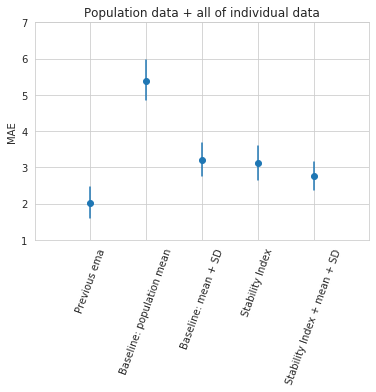

In [117]:
GRAPH_TITLE = 'Population data + all of individual data'
errors_dfs_matrix_mixedall = get_error_df(y_test_allmodels, y_pred_allmodels)
sns.set_style('whitegrid')
ax = sns.tsplot(data=errors_dfs_matrix_mixedall.values, ci=95, err_style = 'ci_bars', interpolate=False, 
                n_boot=10000)
plt.xticks(np.arange(0, 5, step=1), ('Previous ema', 'Baseline: population mean', 'Baseline: mean + SD', 
                                     'Stability Index', 'Stability Index + mean + SD'), rotation=70)
plt.yticks(np.arange(1, 8, step=1))
plt.ylabel('MAE')
plt.title(GRAPH_TITLE)
plt.show()

## mixed models, with 0,5,10,15 user examples

In [118]:
errors_dfs_matrix_mixed0 = pd.DataFrame()
errors_dfs_matrix_mixed5 = pd.DataFrame()
errors_dfs_matrix_mixed10 = pd.DataFrame()
errors_dfs_matrix_mixed15 = pd.DataFrame()

In [121]:
NUM_USER_EXAMPLES = 15
ema_length_old = len(ema)
print('before drop nan prev ema', len(ema))
ema = ema.dropna(subset=['prev_' + EMA_ITEM])
print('after drop nan prev ema', len(ema))
print('previous ema unavailable', (ema_length_old - len(ema))/ema_length_old)
print('users included:',len(ema.groupby('eureka_id').count()))
print('ema_item:', EMA_ITEM)
print('model type:', MODEL_TYPE)
MIN_TRAIN = 2
print('min traing examples: ', MIN_TRAIN)
print('NUM_USER_EXAMPLES: ', NUM_USER_EXAMPLES)
print()

X = ema
y = ema[EMA_ITEM]

uids = ema['eureka_id']
groups = []
for j in range(len(uids)):
    uid_num = int(uids.iloc[j][1:])
    groups.append(uid_num)
    
lpgo = LeavePGroupsOut(n_groups=1)

summary_df = pd.DataFrame() 
y_test_allmodels = []
y_pred_allmodels = []
print(datetime.datetime.now())
for i in range(len(feature_sets)):
    selected_fea = feature_sets[i]
#     print(selected_fea)
    y_test_allusers = []
    y_pred_allusers = []    
    y_train_allusers = []
    y_train_pred_allusers = []
    count = 0
    fea_importances = []
    
    # cross validation aprroach: leave one out on a user level or record level
    for train_index, test_index in lpgo.split(X[selected_fea], y, groups): 
        count = count + 1
        train_index = train_index.tolist()
        test_index = test_index.tolist()
        test_dates = X['day'].values[test_index]
        test_dates = pd.Series(test_dates)
        earliest_test = test_dates.min()
        
        # remove all data points later than the earliest test date  
        train_index = train_index[:test_index[0]]
        train_dates = X.iloc[train_index]['day']
        for t in range(len(train_dates)):
            if pd.to_datetime(train_dates.iloc[t]) >= pd.to_datetime(earliest_test):
                train_index.remove(t)

        # add part of the user's examples into train adn take them out of test
        for n in test_index[len(test_index) - NUM_TEST_PER_USER - NUM_USER_EXAMPLES:len(test_index) - NUM_TEST_PER_USER]:
            train_index.append(n)
        test_index = test_index[len(test_index) - NUM_TEST_PER_USER:]

        if (len(train_index) >= MIN_TRAIN) and ('u018' not in X['eureka_id'].values[test_index]):
            X_train = X[selected_fea].iloc[train_index]
            y_train = y.iloc[train_index]
            X_test = X[selected_fea].iloc[test_index]
            y_test = y.iloc[test_index]

            # add the user bit for train and test
            user_label_test = X['eureka_id'].values[test_index]
            user_labels_train = []
            for u in X['eureka_id'].values[train_index]:
                if u in user_label_test:
                    user_labels_train.append(1)
                else:
                    user_labels_train.append(0)
            X_train['user'] = user_labels_train

            user_labels_test = []
            for u_test in X['eureka_id'].values[test_index]:
                if u_test in user_label_test:
                    user_labels_test.append(1)
                else:
                    user_labels_test.append(0)
            X_test['user'] = user_labels_test
                        
            model = get_model(model, MODEL_TYPE) 
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_train_pred = model.predict(X_train)
            
            # Plot feature importance
            feature_importance = model.feature_importances_
            fea_importances.append(feature_importance)
            # make importances relative to max importance
            feature_importance = 100.0 * (feature_importance / feature_importance.max())
            sorted_idx = np.argsort(feature_importance)
            plt.figure(figsize=(15, 30))
            pos = np.arange(sorted_idx.shape[0]) + .8
            plt.barh(pos, feature_importance[sorted_idx], align='center')
            plt.yticks(pos, X_train.columns[sorted_idx])
            plt.xlabel('Relative Importance')
            plt.title('Variable Importance')
#             plt.savefig('GBRT_graphs' + str(NUM_TEST_PER_USER) + '/mixed_' + str(NUM_USER_EXAMPLES) + '/' + feature_sets_names[i] + '/' + str(count) + '.png', bbox_inches='tight')
            plt.close()
#               plt.show()

            # collect actual values and predicted values in the test set
            for test in y_test:
                y_test_allusers.append(test)
            for pred in y_pred:
                y_pred_allusers.append(pred)

            # collect actual values and predicted values in the train set    
            for train in y_train:
                y_train_allusers.append(train)
            for train_pred in y_train_pred:
                y_train_pred_allusers.append(train_pred)
            
    # test to see if it gives you an r2 of 0 if you always predict the mean
    if 'predictor' in feature_sets_names[i]:
        y_test_allusers_series = pd.Series(y_test_allusers)
        y_train_allusers_series = pd.Series(y_train_allusers)
        if 'mean' in feature_sets_names[i]:
            y_pred_allusers = [POPULATION_MEAN] * len(y_test_allusers)
            y_train_pred_allusers = [y_train_allusers_series.mean()] * len(y_train_allusers)
        elif 'median' in feature_sets_names[i]:
            y_pred_allusers = [y_test_allusers_series.median()] * len(y_test_allusers)
            y_train_pred_allusers = [y_train_allusers_series.median()] * len(y_train_allusers)

    y_test_allmodels.append(y_test_allusers)
    y_pred_allmodels.append(y_pred_allusers)  
    
    r_squared = r2_score(y_test_allusers, y_pred_allusers)
    mae = metrics.mean_absolute_error(y_test_allusers, y_pred_allusers)     

    r_squared_train = r2_score(y_train_allusers, y_train_pred_allusers)
    mae_train = metrics.mean_absolute_error(y_train_allusers, y_train_pred_allusers)
    
    summary_df[feature_sets_names[i]] = [mae, r_squared, mae_train, r_squared_train]
    print('finished ' + feature_sets_names[i], datetime.datetime.now())
summary_df['feature_group'] = ['MAE', 'r2', 'MAE_train', 'r2_train']
summary_df = summary_df.set_index('feature_group')
summary_df = summary_df.transpose()
summary_df

before drop nan prev ema 655
after drop nan prev ema 655
previous ema unavailable 0.0
users included: 14
ema_item: ema_score
model type: gbrt
min traing examples:  2
NUM_USER_EXAMPLES:  15

2020-08-09 00:40:01.044191
finished prev_ema 2020-08-09 00:40:03.260171
finished mean_predictor 2020-08-09 00:40:05.482126
finished baseline_mean_std 2020-08-09 00:40:11.718441
finished just_diff_normal 2020-08-09 00:40:15.890489
finished baseline_diff_normal 2020-08-09 00:40:23.663429


feature_group,MAE,r2,MAE_train,r2_train
prev_ema,2.398681,0.602731,2.221160,0.710740
mean_predictor,5.396384,-0.026474,5.540740,0.000000
baseline_mean_std,3.322735,0.508014,0.129918,0.998953
just_diff_normal,3.792716,0.221690,0.155110,0.998537
baseline_diff_normal,3.588824,0.360959,0.104005,0.999354


In [ ]:
if NUM_USER_EXAMPLES == 0:
    errors_dfs_matrix_mixed0 = get_error_df(y_test_allmodels, y_pred_allmodels)
elif NUM_USER_EXAMPLES == 5:
    errors_dfs_matrix_mixed5 = get_error_df(y_test_allmodels, y_pred_allmodels)
elif NUM_USER_EXAMPLES == 10:
    errors_dfs_matrix_mixed10 = get_error_df(y_test_allmodels, y_pred_allmodels)
elif NUM_USER_EXAMPLES == 15:
    errors_dfs_matrix_mixed15 = get_error_df(y_test_allmodels, y_pred_allmodels)

## individual

In [123]:
ema_length_old = len(ema)
print('before drop nan prev ema', len(ema))
ema = ema.dropna(subset=['prev_' + EMA_ITEM])
print('after drop nan prev ema', len(ema))
print('previous ema unavailable', (ema_length_old - len(ema))/ema_length_old)
print('users included:',len(ema.groupby('eureka_id').count()))
print('ema_item:', EMA_ITEM)
print('model type:', MODEL_TYPE)
MIN_TRAIN = 2
print('min traing examples: ', MIN_TRAIN)
print()

X = ema
y = ema[EMA_ITEM]

uids = ema['eureka_id']
groups = []
for j in range(len(uids)):
    uid_num = int(uids.iloc[j][1:])
    groups.append(uid_num)
    
lpgo = LeavePGroupsOut(n_groups=1)

summary_df = pd.DataFrame() 
y_test_allmodels = []
y_pred_allmodels = []
print(datetime.datetime.now())
for i in range(len(feature_sets)):
    selected_fea = feature_sets[i]
#     print(selected_fea)
    y_test_allusers = []
    y_pred_allusers = []    
    y_train_allusers = []
    y_train_pred_allusers = []
    count = 0
    fea_importances = []
    
    # cross validation aprroach: leave one out on a user level or record level
    for train_index, test_index in lpgo.split(X[selected_fea], y, groups): 
        count = count + 1
        train_index = train_index.tolist()
        test_index = test_index.tolist()
        test_dates = X['day'].values[test_index]
        test_dates = pd.Series(test_dates)
        earliest_test = test_dates.min()     
        train_index = test_index[:len(test_index) - NUM_TEST_PER_USER]
        test_index = test_index[len(test_index) - NUM_TEST_PER_USER:]
        if (len(train_index) >= MIN_TRAIN) and ('u018' not in X['eureka_id'].values[test_index]):
            X_train = X[selected_fea].iloc[train_index]
            y_train = y.iloc[train_index]
            X_test = X[selected_fea].iloc[test_index]
            y_test = y.iloc[test_index]
                        
            model = get_model(model, MODEL_TYPE) 
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_train_pred = model.predict(X_train)
            
            # Plot feature importance
            feature_importance = model.feature_importances_
            fea_importances.append(feature_importance)
            # make importances relative to max importance
            feature_importance = 100.0 * (feature_importance / feature_importance.max())
            sorted_idx = np.argsort(feature_importance)
            plt.figure(figsize=(15, 30))
            pos = np.arange(sorted_idx.shape[0]) + .8
            plt.barh(pos, feature_importance[sorted_idx], align='center')
            plt.yticks(pos, X_train.columns[sorted_idx])
            plt.xlabel('Relative Importance')
            plt.title('Variable Importance')
#             plt.savefig('GBRT_graphs' + str(NUM_TEST_PER_USER) + '/individual_all/' + feature_sets_names[i] + '/' + str(count) + '.png', bbox_inches='tight')
            plt.close()

            # collect actual values and predicted values in the test set
            for test in y_test:
                y_test_allusers.append(test)
            for pred in y_pred:
                y_pred_allusers.append(pred)

            # collect actual values and predicted values in the train set    
            for train in y_train:
                y_train_allusers.append(train)
            for train_pred in y_train_pred:
                y_train_pred_allusers.append(train_pred)
            
    # test to see if it gives you an r2 of 0 if you always predict the mean
    if 'predictor' in feature_sets_names[i]:
        y_test_allusers_series = pd.Series(y_test_allusers)
        y_train_allusers_series = pd.Series(y_train_allusers)
        if 'mean' in feature_sets_names[i]:
            y_pred_allusers = [POPULATION_MEAN] * len(y_test_allusers)
            y_train_pred_allusers = [y_train_allusers_series.mean()] * len(y_train_allusers)
        elif 'median' in feature_sets_names[i]:
            y_pred_allusers = [y_test_allusers_series.median()] * len(y_test_allusers)
            y_train_pred_allusers = [y_train_allusers_series.median()] * len(y_train_allusers)
#     print('len:', len(y_test_allusers))

    y_test_allmodels.append(y_test_allusers)
    y_pred_allmodels.append(y_pred_allusers)
    
    r_squared = r2_score(y_test_allusers, y_pred_allusers)
    mae = metrics.mean_absolute_error(y_test_allusers, y_pred_allusers)      

    r_squared_train = r2_score(y_train_allusers, y_train_pred_allusers)
    mae_train = metrics.mean_absolute_error(y_train_allusers, y_train_pred_allusers)

    # graph total feature importance
    total_importance = fea_importances[0]
    for fea_idx in range(len(fea_importances)-1):
        total_importance = np.add(total_importance, fea_importances[fea_idx+1])
    total_importance = 100.0 * (total_importance / total_importance.max())
    sorted_idx = np.argsort(total_importance)
    plt.figure(figsize=(15, 30))
    pos = np.arange(sorted_idx.shape[0]) + .8
    plt.barh(pos, total_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative importance')
    plt.title('Variable importance')
#     plt.savefig('GBRT_graphs' + str(NUM_TEST_PER_USER) + '/individual_all_' + feature_sets_names[i]  + '.png', bbox_inches='tight')
    plt.close()
    
    summary_df[feature_sets_names[i]] = [mae, r_squared, mae_train, r_squared_train]
    print('finished ' + feature_sets_names[i], datetime.datetime.now())
summary_df['feature_group'] = ['MAE', 'r2', 'MAE_train', 'r2_train']
summary_df = summary_df.set_index('feature_group')
summary_df = summary_df.transpose()
summary_df

before drop nan prev ema 655
after drop nan prev ema 655
previous ema unavailable 0.0
users included: 14
ema_item: ema_score
model type: gbrt
min traing examples:  2

2020-08-09 00:43:36.668146


/homes/gws/joyhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


finished prev_ema 2020-08-09 00:43:38.620431


/homes/gws/joyhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


finished mean_predictor 2020-08-09 00:43:40.575870


/homes/gws/joyhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


finished baseline_mean_std 2020-08-09 00:43:44.465153


/homes/gws/joyhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


finished just_diff_normal 2020-08-09 00:43:47.282925


/homes/gws/joyhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


finished baseline_diff_normal 2020-08-09 00:43:51.614266


feature_group,MAE,r2,MAE_train,r2_train
prev_ema,2.060507,0.740114,1.498818,0.844423
mean_predictor,5.396384,-0.026474,4.930489,0.000000
baseline_mean_std,2.985049,0.543569,0.000235,1.000000
just_diff_normal,2.457555,0.628031,0.000248,1.000000
baseline_diff_normal,2.682327,0.636357,0.000236,1.000000


In [129]:
errors_dfs_matrix_individual = get_error_df(y_test_allmodels, y_pred_allmodels)
upper_bound = errors_dfs_matrix_individual['mean_predictor'].mean()
lower_bound = errors_dfs_matrix_individual['prev_ema'].mean()
errors_dfs_matrix_individual = errors_dfs_matrix_individual[['prev_ema', 'baseline_mean_std', 'just_diff_normal', 'baseline_diff_normal']]

2.060506555849109
5.39638415476739
2.9850485476965223
2.457554869180211
2.6823270304873392


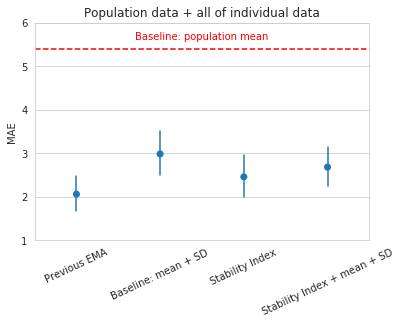

In [130]:
sns.set_style('whitegrid')
ax = sns.pointplot(data=errors_dfs_matrix_individual.values,
                   markers=['o'],
                   ci=95, n_boot=10000, 
                   scale = 0.8,
                   errwidth = 1.5,
                   join = False
                  )
plt.xticks(np.arange(0, 4, step=1), ('Previous EMA', 'Baseline: mean + SD', 
                                     'Stability Index', 'Stability Index + mean + SD'), rotation=25)
plt.yticks(np.arange(1, 7, step=1))
# 'Previous EMA', 'Baseline: population mean', 
plt.axhline(y = upper_bound, color='r', linestyle = '--')
plt.text(0.7, 5.625, 'Baseline: population mean', color='r')
# plt.axhline(y = lower_bound, color='g', linestyle = '-.')
# plt.text(0.7, lower_bound - 0.4, 'Previous EMA', color='g')
plt.ylabel('MAE')
plt.title(GRAPH_TITLE)
# plt.savefig('prediction_graphs' + str(NUM_TEST_PER_USER) + '/' + GRAPH_TITLE + 
#             str(errors_dfs_matrix_individual['baseline_diff_normal'].mean()) +'.pdf', bbox_inches='tight', dpi=1200)    
plt.show()

## individual, with 5,10,15 user examples

In [ ]:
errors_dfs_matrix_individual0 = pd.DataFrame()
errors_dfs_matrix_individual5 = pd.DataFrame()
errors_dfs_matrix_individual10 = pd.DataFrame()
errors_dfs_matrix_individual15 = pd.DataFrame()

In [131]:
NUM_USER_EXAMPLES = 15
ema_length_old = len(ema)
print('before drop nan prev ema', len(ema))
ema = ema.dropna(subset=['prev_' + EMA_ITEM])
print('after drop nan prev ema', len(ema))
print('previous ema unavailable', (ema_length_old - len(ema))/ema_length_old)
print('users included:',len(ema.groupby('eureka_id').count()))
print('ema_item:', EMA_ITEM)
print('model type:', MODEL_TYPE)
# MIN_TRAIN = PERCENTAGE_TRAIN_MIN * len(ema)
MIN_TRAIN = 2
print('min traing examples: ', MIN_TRAIN)
print()

X = ema
y = ema[EMA_ITEM]

uids = ema['eureka_id']
groups = []
for j in range(len(uids)):
    uid_num = int(uids.iloc[j][1:])
    groups.append(uid_num)
    
lpgo = LeavePGroupsOut(n_groups=1)

summary_df = pd.DataFrame()  
y_test_allmodels = []
y_pred_allmodels = []
print(datetime.datetime.now())
for i in range(len(feature_sets)):
    selected_fea = feature_sets[i]
#     print(selected_fea)
    y_test_allusers = []
    y_pred_allusers = []    
    y_train_allusers = []
    y_train_pred_allusers = []
    count = 0
    
    # cross validation aprroach: leave one out on a user level or record level
    for train_index, test_index in lpgo.split(X[selected_fea], y, groups): 
        count = count + 1
        train_index = train_index.tolist()
        test_index = test_index.tolist()
        test_dates = X['day'].values[test_index]
        test_dates = pd.Series(test_dates)
        earliest_test = test_dates.min()
        
        train_index = test_index[len(test_index) - NUM_TEST_PER_USER - NUM_USER_EXAMPLES:len(test_index) - NUM_TEST_PER_USER]
        test_index = test_index[len(test_index) - NUM_TEST_PER_USER:]

        if (len(train_index) >= MIN_TRAIN) and ('u018' not in X['eureka_id'].values[test_index]):
            X_train = X[selected_fea].iloc[train_index]
            y_train = y.iloc[train_index]
            X_test = X[selected_fea].iloc[test_index]
            y_test = y.iloc[test_index]
                        
            model = get_model(model, MODEL_TYPE) 
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_train_pred = model.predict(X_train)
            
            # Plot feature importance
            feature_importance = model.feature_importances_
            # make importances relative to max importance
            feature_importance = 100.0 * (feature_importance / feature_importance.max())
            sorted_idx = np.argsort(feature_importance)
            plt.figure(figsize=(15, 30))
            pos = np.arange(sorted_idx.shape[0]) + .8
            plt.barh(pos, feature_importance[sorted_idx], align='center')
            plt.yticks(pos, X_train.columns[sorted_idx])
            plt.xlabel('Relative Importance')
            plt.title('Variable Importance')
#             plt.savefig('GBRT_graphs' + str(NUM_TEST_PER_USER) + '/individual_' + str(NUM_USER_EXAMPLES) +'/' + feature_sets_names[i] + '/' + str(count) + '.png', bbox_inches='tight')
            plt.close()

            # collect actual values and predicted values in the test set
            for test in y_test:
                y_test_allusers.append(test)
            for pred in y_pred:
                y_pred_allusers.append(pred)

            # collect actual values and predicted values in the train set    
            for train in y_train:
                y_train_allusers.append(train)
            for train_pred in y_train_pred:
                y_train_pred_allusers.append(train_pred)
            
    # test to see if it gives you an r2 of 0 if you always predict the mean
    if 'predictor' in feature_sets_names[i]:
        y_test_allusers_series = pd.Series(y_test_allusers)
        y_train_allusers_series = pd.Series(y_train_allusers)
        if 'mean' in feature_sets_names[i]:
            y_pred_allusers = [POPULATION_MEAN] * len(y_test_allusers)
            y_train_pred_allusers = [y_train_allusers_series.mean()] * len(y_train_allusers)
        elif 'median' in feature_sets_names[i]:
            y_pred_allusers = [y_test_allusers_series.median()] * len(y_test_allusers)
            y_train_pred_allusers = [y_train_allusers_series.median()] * len(y_train_allusers)

    y_test_allmodels.append(y_test_allusers)
    y_pred_allmodels.append(y_pred_allusers)
    
    r_squared = r2_score(y_test_allusers, y_pred_allusers)
    mae = metrics.mean_absolute_error(y_test_allusers, y_pred_allusers)      

    r_squared_train = r2_score(y_train_allusers, y_train_pred_allusers)
    mae_train = metrics.mean_absolute_error(y_train_allusers, y_train_pred_allusers)
    
    summary_df[feature_sets_names[i]] = [mae, r_squared, mae_train, r_squared_train]
    print('finished ' + feature_sets_names[i], datetime.datetime.now())
summary_df['feature_group'] = ['MAE', 'r2', 'MAE_train', 'r2_train']
summary_df = summary_df.set_index('feature_group')
summary_df = summary_df.transpose()
summary_df

before drop nan prev ema 655
after drop nan prev ema 655
previous ema unavailable 0.0
users included: 14
ema_item: ema_score
model type: gbrt
min traing examples:  2

2020-08-09 00:52:45.082609


/homes/gws/joyhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


finished prev_ema 2020-08-09 00:52:47.351633


/homes/gws/joyhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


finished mean_predictor 2020-08-09 00:52:49.278754


/homes/gws/joyhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


finished baseline_mean_std 2020-08-09 00:52:52.294548


/homes/gws/joyhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


finished just_diff_normal 2020-08-09 00:52:54.800231


/homes/gws/joyhe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


finished baseline_diff_normal 2020-08-09 00:52:58.701681


feature_group,MAE,r2,MAE_train,r2_train
prev_ema,2.256154,0.669025,0.892821,0.922421
mean_predictor,5.396384,-0.026474,4.873162,0.000000
baseline_mean_std,2.528101,0.620038,0.000218,1.000000
just_diff_normal,2.567490,0.648018,0.000218,1.000000
baseline_diff_normal,2.556398,0.637736,0.000214,1.000000


# filter

In [55]:
NUM_GOOD_DAYS_REQUIRED = 7
def get_filtered_table(num_days_used, num_days_blocked, num_good_days_required):
    table0 = pd.read_csv('table_ema_'+str(NUM_DAYS_USED)+'_'+str(NUM_DAYS_BLOCKED)+'.csv')
    table0 = table0.drop(['Unnamed: 0'], axis=1) 
    num_good_days_cols = [c for c in table0.columns if 'num_good_days' in c]
    for i in range(len(num_good_days_cols)):        
        table0 = table0.loc[table0[num_good_days_cols[i]] >= num_good_days_required]
    return table0

table0_filtered = get_filtered_table(NUM_DAYS_USED, NUM_DAYS_BLOCKED, NUM_GOOD_DAYS_REQUIRED)
print(len(table0_filtered))
if 'prev_ema_severity' in table0_filtered:
    table0_filtered = table0_filtered.drop(['prev_ema_severity'], axis=1)
table0_filtered = table0_filtered.dropna()
print(len(table0_filtered))
print(len(table0_filtered.columns))

779
779
118


# EMA Correlation table 

In [50]:
corr_table = table0_filtered.corr(method ='pearson') 

In [51]:
row_index = [r for r in corr_table.index if "ema" in r]
col_index = [c for c in corr_table.columns if 'ema' not in c]
corr_table_small = corr_table.loc[row_index, col_index]
corr_table_small

,calllog_avg,calllog_med_mean,calllog_med_mean_normal,calllog_med_mean_raw,calllog_num_good_days,calllog_std,sms_in_avg,sms_in_med_mean,sms_in_med_mean_normal,sms_in_med_mean_raw,sms_in_num_good_days,sms_in_std,sms_out_avg,sms_out_med_mean,sms_out_med_mean_normal,sms_out_med_mean_raw,sms_out_num_good_days,sms_out_std,unlock_avg,unlock_med_mean,unlock_med_mean_normal,unlock_med_mean_raw,unlock_num_good_days,unlock_std,conver_avg,conver_med_mean,conver_med_mean_normal,conver_med_mean_raw,conver_num_good_days,conver_std,sleep_avg,sleep_med_mean,sleep_med_mean_normal,sleep_med_mean_raw,sleep_num_good_days,sleep_std,act_invehicle_avg,act_invehicle_med_mean,act_invehicle_med_mean_normal,act_invehicle_med_mean_raw,act_invehicle_num_good_days,act_invehicle_std,act_onbike_avg,act_onbike_med_mean,act_onbike_med_mean_normal,act_onbike_med_mean_raw,act_onbike_num_good_days,act_onbike_std,act_onfoot_avg,act_onfoot_med_mean,act_onfoot_med_mean_normal,act_onfoot_med_mean_raw,act_onfoot_num_good_days,act_onfoot_std,act_still_avg,act_still_med_mean,act_still_med_mean_normal,act_still_med_mean_raw,act_still_num_good_days,act_still_std,act_tilting_avg,act_tilting_med_mean,act_tilting_med_mean_normal,act_tilting_med_mean_raw,act_tilting_num_good_days,act_tilting_std,act_unknown_avg,act_unknown_med_mean,act_unknown_med_mean_normal,act_unknown_med_mean_raw,act_unknown_num_good_days,act_unknown_std,light_avg,light_med_mean,light_med_mean_normal,light_med_mean_raw,light_num_good_days,light_std,audio_amp_avg,audio_amp_med_mean,audio_amp_med_mean_normal,audio_amp_med_mean_raw,audio_amp_num_good_days,audio_amp_std,audio_noise_avg,audio_noise_med_mean,audio_noise_med_mean_normal,audio_noise_med_mean_raw,audio_noise_num_good_days,audio_noise_std,audio_silence_avg,audio_silence_med_mean,audio_silence_med_mean_normal,audio_silence_med_mean_raw,audio_silence_num_good_days,audio_silence_std,audio_voice_avg,audio_voice_med_mean,audio_voice_med_mean_normal,audio_voice_med_mean_raw,audio_voice_num_good_days,audio_voice_std
ema_CALM,0.152231,0.057268,-0.235481,0.148737,0.033244,0.053935,0.336018,0.282321,-0.185983,0.325702,0.186328,0.308220,0.324250,0.267883,-0.253201,0.319976,0.186328,0.282675,0.394095,0.326413,-0.165867,0.389861,NaN,0.205440,0.019992,-0.048081,-0.126908,0.037880,-0.035921,-0.110082,-0.219630,-0.020379,-0.056714,0.060684,NaN,-0.109672,-0.118141,-0.034295,-0.043760,-0.138544,0.003942,-0.005381,-0.028289,-0.046814,-0.127906,-0.043678,0.003942,0.035413,0.218445,0.238504,-0.088383,0.188672,0.003942,0.243873,0.075521,0.068684,0.195590,-0.143369,0.003942,0.148492,0.149446,0.115944,0.093635,0.127926,0.003942,0.143342,-0.173666,-0.135916,0.040749,-0.167860,0.003942,-0.113605,-0.023075,-0.030026,-0.021549,-0.040911,NaN,-0.043721,-0.060042,-0.011146,0.019288,-0.043559,-0.036336,0.036213,0.041403,0.065635,0.058288,0.060523,-0.036336,0.054567,-0.033814,0.047645,0.111091,0.011801,-0.036336,0.020215,-0.029849,-0.059201,-0.092760,-0.010772,-0.036336,-0.095652
ema_DEPRESSED,-0.156828,-0.147429,-0.065203,-0.148066,-0.051535,-0.140858,-0.243081,-0.223415,0.014333,-0.241474,-0.246188,-0.275598,-0.245147,-0.236409,0.022568,-0.246760,-0.246188,-0.260056,-0.276957,-0.268752,0.059024,-0.278304,NaN,-0.109967,-0.112927,-0.134601,-0.097463,-0.150763,0.034880,-0.060301,0.314849,-0.224679,-0.244440,-0.255016,NaN,-0.077329,0.076422,-0.061004,-0.163721,0.069266,-0.024222,-0.084959,-0.061646,-0.069127,-0.052572,-0.052323,-0.024222,-0.063026,-0.126995,-0.214952,-0.186326,-0.115210,-0.024222,-0.173974,-0.119350,-0.127476,-0.173686,0.122004,-0.024222,-0.166094,-0.120587,-0.204684,-0.206640,-0.117186,-0.024222,-0.160255,0.197983,0.097224,-0.096038,0.163450,-0.024222,0.062897,0.121384,0.120661,-0.118196,0.141920,NaN,0.085568,-0.045672,-0.125837,-0.199839,-0.060358,0.020100,-0.059309,0.062960,-0.029078,-0.095004,-0.143839,0.020100,-0.005431,-0.039728,-0.204385,-0.038676,-0.171555,0.020100,-0.145105,-0.103122,-0.092166,-0.117114,-0.135677,0.020100,-0.052058
ema_HARM,-0.105961,-0.076

# p values

In [52]:
p_table = get_p_values(table0_filtered)
p_table_small = p_table.loc[row_index, col_index]
p_table_small

,calllog_avg,calllog_med_mean,calllog_med_mean_normal,calllog_med_mean_raw,calllog_num_good_days,calllog_std,sms_in_avg,sms_in_med_mean,sms_in_med_mean_normal,sms_in_med_mean_raw,sms_in_num_good_days,sms_in_std,sms_out_avg,sms_out_med_mean,sms_out_med_mean_normal,sms_out_med_mean_raw,sms_out_num_good_days,sms_out_std,unlock_avg,unlock_med_mean,unlock_med_mean_normal,unlock_med_mean_raw,unlock_num_good_days,unlock_std,conver_avg,conver_med_mean,conver_med_mean_normal,conver_med_mean_raw,conver_num_good_days,conver_std,sleep_avg,sleep_med_mean,sleep_med_mean_normal,sleep_med_mean_raw,sleep_num_good_days,sleep_std,act_invehicle_avg,act_invehicle_med_mean,act_invehicle_med_mean_normal,act_invehicle_med_mean_raw,act_invehicle_num_good_days,act_invehicle_std,act_onbike_avg,act_onbike_med_mean,act_onbike_med_mean_normal,act_onbike_med_mean_raw,act_onbike_num_good_days,act_onbike_std,act_onfoot_avg,act_onfoot_med_mean,act_onfoot_med_mean_normal,act_onfoot_med_mean_raw,act_onfoot_num_good_days,act_onfoot_std,act_still_avg,act_still_med_mean,act_still_med_mean_normal,act_still_med_mean_raw,act_still_num_good_days,act_still_std,act_tilting_avg,act_tilting_med_mean,act_tilting_med_mean_normal,act_tilting_med_mean_raw,act_tilting_num_good_days,act_tilting_std,act_unknown_avg,act_unknown_med_mean,act_unknown_med_mean_normal,act_unknown_med_mean_raw,act_unknown_num_good_days,act_unknown_std,light_avg,light_med_mean,light_med_mean_normal,light_med_mean_raw,light_num_good_days,light_std,audio_amp_avg,audio_amp_med_mean,audio_amp_med_mean_normal,audio_amp_med_mean_raw,audio_amp_num_good_days,audio_amp_std,audio_noise_avg,audio_noise_med_mean,audio_noise_med_mean_normal,audio_noise_med_mean_raw,audio_noise_num_good_days,audio_noise_std,audio_silence_avg,audio_silence_med_mean,audio_silence_med_mean_normal,audio_silence_med_mean_raw,audio_silence_num_good_days,audio_silence_std,audio_voice_avg,audio_voice_med_mean,audio_voice_med_mean_normal,audio_voice_med_mean_raw,audio_voice_num_good_days,audio_voice_std
ema_CALM,0.001733,0.240995,1.028161e-06,0.002215,0.496332,0.269523,1.431817e-12,3.726871e-09,0.000124,7.351419e-12,1.203142e-04,1.024089e-10,9.208220e-12,2.370669e-08,1.395392e-07,1.775173e-11,1.203142e-04,3.556869e-09,4.290552e-17,6.580401e-12,0.000633,9.861733e-17,NaN,0.000022,0.682519,0.325032,0.009141,0.438221,0.462286,0.023893,5.397979e-06,0.676717,2.455841e-01,2.140221e-01,NaN,0.024424,0.015294,0.482815,0.370445,0.004400,0.935723,0.912352,0.562700,0.337957,0.008604,0.371343,0.935723,0.468642,6.081211e-06,7.392503e-07,0.070044,9.830219e-05,0.935723,4.069875e-07,0.121822,0.159501,5.337865e-05,0.003196,0.935723,0.002253,0.002108,0.017315,0.054891,0.008593,0.935723,0.003202,0.000344,0.005215,0.404301,0.000543,0.935723,0.019721,0.636840,0.538953,0.659303,0.402437,NaN,0.370872,0.218921,0.819624,0.693123,0.372646,4.571282e-01,0.458653,3.967933e-01,0.178893,2.326992e-01,0.215245,4.571282e-01,0.263937,4.889751e-01,0.329442,2.262717e-02,8.092224e-01,4.571282e-01,6.791820e-01,0.541351,0.225457,0.057207,0.825577,4.571282e-01,0.049847
ema_DEPRESSED,0.001245,0.002425,1.817819e-01,0.002320,0.291442,0.003779,4.448282e-07,3.672698e-06,0.769345,5.322692e-07,3.132653e-07,8.940140e-09,3.525311e-07,9.295249e-07,6.442644e-01,2.935502e-07,3.132653e-07,6.181955e-08,7.505012e-09,2.127281e-08,0.226849,6.303617e-09,NaN,0.024041,0.020471,0.005672,0.045653,0.001923,0.475365,0.216934,3.848265e-11,0.000003,3.817955e-07,1.127416e-07,NaN,0.113121,0.117423,0.211617,0.000746,0.155988,0.620178,0.081652,0.206837,0.156820,0.281830,0.284115,0.620178,0.196834,9.092978e-03,8.609106e-06,0.000120,1.804151e-02,0.620178,3.352512e-04,0.014272,0.008832,3.430718e-04,0.012237,0.620178,0.000622,0.013289,0.000023,0.000019,0.016146,0.620178,0.000968,0.000043,0.046190,0.048927,0.000762,0.620178,0.197755,0.012688,0.013233,0.015246,0.003522,NaN,0.079479,0.349886,0.009750,0.000036,0.216500,6.808976e-01,0.224610,1.973031e-01,0.551859,5.142348e-02,0.003097,6.808976e-01,0.911526,4.161858e-01,0.0

# print r in order for each ema score

In [53]:
row_index = [r for r in corr_table.index if "ema" in r]
col_index_med_mean = [c for c in corr_table.columns if 'med_mean' in c and 'raw' not in c]
corr_table_small_med_mean = corr_table.loc[row_index, col_index_med_mean]
# print r in desceding order for each ema score
ordered_list_all = pd.DataFrame()
for i in corr_table_small_med_mean.index:
#     print(i)
    ordered_list = corr_table_small_med_mean.loc[i].sort_values(ascending=False).rename('diff')
    ordered_list = ordered_list.to_frame()
    ordered_list = ordered_list.reset_index()
#     print(ordered_list)
    means = []
    stds = []
    num_days = []
    pvals_diff = []
    pvals_mean = []
    pvals_std = []
    pvals_num_days = []
    for item in ordered_list['index']:
        pvals_diff.append(p_table.loc[i][item])
        
        if behavior_names[0] in item:
            means.append(corr_table_small.loc[i][behavior_names[0] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[0] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[0] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[0] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[0] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[0] + '_num_good_days'])
        if behavior_names[1] in item:
            means.append(corr_table_small.loc[i][behavior_names[1] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[1] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[1] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[1] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[1] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[1] + '_num_good_days'])
        if behavior_names[2] in item:
            means.append(corr_table_small.loc[i][behavior_names[2] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[2] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[2] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[2] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[2] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[2] + '_num_good_days'])
        if behavior_names[3] in item:
            means.append(corr_table_small.loc[i][behavior_names[3] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[3] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[3] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[3] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[3] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[3] + '_num_good_days'])
        if behavior_names[4] in item:
            means.append(corr_table_small.loc[i][behavior_names[4] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[4] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[4] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[4] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[4] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[4] + '_num_good_days'])
        if behavior_names[5] in item:
            means.append(corr_table_small.loc[i][behavior_names[5] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[5] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[5] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[5] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[5] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[5] + '_num_good_days'])
        if behavior_names[6] in item:
            means.append(corr_table_small.loc[i][behavior_names[6] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[6] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[6] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[6] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[6] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[6] + '_num_good_days'])
        if behavior_names[7] in item:
            means.append(corr_table_small.loc[i][behavior_names[7] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[7] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[7] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[7] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[7] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[7] + '_num_good_days'])
        if behavior_names[8] in item:
            means.append(corr_table_small.loc[i][behavior_names[8] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[8] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[8] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[8] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[8] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[8] + '_num_good_days'])
        if behavior_names[9] in item:
            means.append(corr_table_small.loc[i][behavior_names[9] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[9] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[9] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[9] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[9] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[9] + '_num_good_days'])
        if behavior_names[10] in item:
            means.append(corr_table_small.loc[i][behavior_names[10] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[10] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[10] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[10] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[10] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[10] + '_num_good_days'])
        if behavior_names[11] in item:
            means.append(corr_table_small.loc[i][behavior_names[11] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[11] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[11] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[11] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[11] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[11] + '_num_good_days'])
        if behavior_names[12] in item:
            means.append(corr_table_small.loc[i][behavior_names[12] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[12] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[12] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[12] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[12] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[12] + '_num_good_days'])
        if behavior_names[13] in item:
            means.append(corr_table_small.loc[i][behavior_names[13] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[13] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[13] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[13] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[13] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[13] + '_num_good_days'])
        if behavior_names[14] in item:
            means.append(corr_table_small.loc[i][behavior_names[14] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[14] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[14] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[14] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[14] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[14] + '_num_good_days'])
        if behavior_names[15] in item:
            means.append(corr_table_small.loc[i][behavior_names[15] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[15] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[15] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[15] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[15] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[15] + '_num_good_days'])
        if behavior_names[16] in item:
            means.append(corr_table_small.loc[i][behavior_names[16] + '_avg'])
            stds.append(corr_table_small.loc[i][behavior_names[16] + '_std'])
            num_days.append(corr_table_small.loc[i][behavior_names[16] + '_num_good_days'])
            pvals_mean.append(p_table.loc[i][behavior_names[16] + '_avg'])
            pvals_std.append(p_table.loc[i][behavior_names[16] + '_std'])
            pvals_num_days.append(p_table.loc[i][behavior_names[16] + '_num_good_days'])
    ordered_list['mean'] = means
    ordered_list['std'] = stds                                     
    ordered_list['p_diff'] = pvals_diff
    ordered_list['p_mean'] = pvals_mean
    ordered_list['p_std'] = pvals_std                                        
    ordered_list['ema_item'] = [i] * len(ordered_list)
    ordered_list_all = pd.concat([ordered_list_all, ordered_list])

ordered_list_all 

,index,diff,mean,std,p_diff,p_mean,p_std,ema_item
0,unlock_med_mean,0.326413,0.394095,0.205440,6.580401e-12,4.290552e-17,2.155429e-05,ema_CALM
1,sms_in_med_mean,0.282321,0.336018,0.308220,3.726871e-09,1.431817e-12,1.024089e-10,ema_CALM
2,sms_out_med_mean,0.267883,0.324250,0.282675,2.370669e-08,9.208220e-12,3.556869e-09,ema_CALM
3,act_onfoot_med_mean,0.238504,0.218445,0.243873,7.392503e-07,6.081211e-06,4.069875e-07,ema_CALM
4,act_still_med_mean_normal,0.195590,0.075521,0.148492,5.337865e-05,1.218222e-01,2.252885e-03,ema_CALM
5,act_tilting_med_mean,0.115944,0.149446,0.143342,1.731545e-02,2.108265e-03,3.202258e-03,ema_CALM
6,audio_silence_med_mean_normal,0.111091,-0.033814,0.020215,2.262717e-02,4.889751e-01,6.791820e-01,ema_CALM
7,act_tilting_med_mean_normal,0.093635,0.149446,0.143342,5.489055e-02,2.108265e-03,3.202258e-03,ema_CALM
8,act_still_med_mean,0.068684,0.075521,0.148492,1.595011e-01,1.218222e-01,2.252885e-03,ema_CALM
9,audio_noise_med_mean,0.065635,0.041403,0.054567,1.788930e-01,3.967933e-01,2.639371e-01,ema_CALM


In [46]:
ordered_list_all['p_diff'] = ordered_list_all['p_diff']*17

In [40]:
ordered_list_all 

,index,diff,mean,std,p_diff,p_mean,p_std,ema_item
0,unlock_med_mean,0.300632,0.409796,0.190146,1.513256e-15,4.701286e-31,2.141588e-07,ema_CALM
1,sms_in_med_mean,0.269587,0.298444,0.276995,1.928791e-12,1.517319e-16,2.232652e-14,ema_CALM
2,sms_out_med_mean,0.262191,0.304483,0.266904,9.304905e-12,3.442635e-17,2.019378e-13,ema_CALM
3,act_onfoot_med_mean,0.208626,0.179987,0.221193,2.018274e-07,9.354943e-07,1.417507e-09,ema_CALM
4,act_still_med_mean_normal,0.194344,0.102774,0.178992,1.933160e-06,5.350770e-03,1.076096e-06,ema_CALM
5,audio_silence_med_mean,0.123576,-0.006685,0.081252,1.359814e-02,8.566236e-01,2.782830e-02,ema_CALM
6,act_still_med_mean,0.112798,0.102774,0.178992,3.782371e-02,5.350770e-03,1.076096e-06,ema_CALM
7,audio_noise_med_mean,0.110324,0.005441,0.074219,4.728120e-02,8.830896e-01,4.456300e-02,ema_CALM
8,act_unknown_med_mean_normal,0.107295,-0.193212,-0.033243,6.176827e-02,1.350558e-07,3.687884e-01,ema_CALM
9,act_tilting_med_mean,0.091376,0.157441,0.125016,2.265886e-01,1.852043e-05,6.933200e-04,ema_CALM


In [43]:
ordered_list_all.to_csv(r'corr_ema_'+str(NUM_DAYS_USED)+'_'+str(NUM_DAYS_BLOCKED)+'_filter'+ str(NUM_GOOD_DAYS_REQUIRED) +'.csv', index=False)

# correlation between distance measure and mean

In [ ]:
corr_mean = pd.DataFrame()
absolutes = []
normals = []
absolute_normals = []
pvals_absolute = []
pvals_normal = []
pvals_absolute_normals = []
for behavior in behavior_names:
    absolutes.append(corr_table.loc[behavior + '_med_mean', behavior + '_avg'])
    normals.append(corr_table.loc[behavior + '_med_mean_normal', behavior + '_avg'])
    absolute_normals.append(corr_table.loc[behavior + '_med_mean', behavior + '_med_mean_normal'])
    pvals_absolute.append(p_table.loc[behavior + '_med_mean', behavior + '_avg'])
    pvals_normal.append(p_table.loc[behavior + '_med_mean_normal', behavior + '_avg'])
    pvals_absolute_normals.append(p_table.loc[behavior + '_med_mean', behavior + '_med_mean_normal'])
corr_mean['abs_diff&mean'] = absolutes
corr_mean['normal_diff&mean'] = normals
corr_mean['abs&normal'] = absolute_normals
corr_mean['p_abs'] = pvals_absolute
corr_mean['p_normal'] = pvals_normal
corr_mean['p_abs_normal'] = pvals_absolute_normals
corr_mean['behavior'] = behavior_names
corr_mean = corr_mean.set_index('behavior')

corr_mean